<a href="https://colab.research.google.com/github/nadje/Parkinsons-Disease-Classification/blob/main/dataset1_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn import datasets, metrics
from sklearn.metrics import confusion_matrix as CM

from sklearn.preprocessing import StandardScaler #importa el módulo para estandarizar
from sklearn.decomposition import PCA #importa el módulo para hacer análisis de componentes principales (PCA)
from sklearn.model_selection import train_test_split #importa el paquete para hacer el split training-test
from sklearn.linear_model import LogisticRegression #importa el paquete para hacer Logistic Regression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier #importa el paquete para hacer modelos ensemble
from sklearn.ensemble import GradientBoostingClassifier #importa el paquete para hacer Gradient Boosting
from sklearn.neighbors import KNeighborsClassifier #importa el paquete para usar el clasificador k-NN 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score, plot_roc_curve,precision_score, recall_score, f1_score, roc_curve
from sklearn.metrics import precision_recall_curve #importa la curva precision-recall 
import bisect #importa el módulo para dar soporte a mantener una lista en orden sin tener que hacer sort después de cada inserción
from scipy.stats import mstats #importa módulo para evaluar objetos estadísticos
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn import tree
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

from sklearn.decomposition import FastICA
from sklearn.metrics import accuracy_score, log_loss
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# ¿Qué indica cada variable?

- **name** - código del sujeto y de la grabación
- **MDVP:Fo(Hz)** - Frecuencia fundamental vocal media
- **MDVP:Fhi(Hz)** - Frecuencia fundamental vocal máxima
- **MDVP:Flo(Hz)** - Frecuencia fundamental vocal mínima
- **MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP** - Diversas medidas que miden la variación en la frecuencia fundamental
- **MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA** - Diversas medidas que miden variación en la amplitud
- **NHR, HNR** - Dos medidas que miden el ratio ruido-armónicos (Noise to Harmonic Ratio, NHR) y el ratio armónicos-ruido (Harmonic to Noise Ratio, HNR)
- **status** - Indica el estado de salud del sujeto: sano (0) o con Parkinson (1)
- **RPDE, D2** - Dos medidas de complejidad dinámica no lineales 
- **DFA** - Exponente de escala fractal de señal
- **spread1, spread2, PPE** - Tres medidas no lineales de variación en frecuencia fundamental

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [41]:
url = 'https://raw.githubusercontent.com/nadje/Parkinsons-Disease-Classification/main/parkinsons.data'
dat = pd.read_csv(url)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

# Análisis exploratorio de los datos

## Definición de algunas funciones generales para representar los datos y generar descriptivos

In [ ]:
def pie_chart(perc):
  '''
  esta función representa un gráfico de sectores dados los porcentajes 
  de cada clase del dataset
  IN
  perc: una lista con los porcentakes de las dos clases
  '''
  explode = (0, 0.2)
  labels_ = ['Parkinson', 'Controls']
  fig, ax = plt.subplots(figsize=(8,8))
  ax.pie(perc, explode=explode, labels=labels_, autopct='%1.4f%%',
        shadow=False, startangle=90)
  plt.title("Class percentages in the dataset")
  plt.show()

def exploratory_analysis(df):
  '''
  esta función aplica una serie de análisis exploratorios
  IN
  df: el dataframe de pandas dataframe con el dataset
  '''
  parkinson = len(df['status'][df['status'] == 1])
  control = len(df['status'][df['status'] == 0])
  print("Shape of dataframe: ", df.shape, "\n", "Total rows: ", len(df) , "\n", 
        "Missing values: ", df.isna().sum().any(), "\n" , 
        "Total parkinson: ", parkinson, " --> ", 
        round(parkinson*100/len(df),4), "% \n", 
        "Total control: ", control, " --> ",
        round(control*100/len(df),4), "%")
  pie_chart([round(parkinson*100/len(df),4),round(control*100/len(df),4)])
  print("---------------------------------------")
  print("Columns and data types: ", df.info())
  print("---------------------------------------")
  print(df.describe())

def plot_features(df, class_name, column1, column2):
  '''
  función para representar dos variables frente otra (estado salud)
  IN
  df: dataframe de pandas dataframe con el dataset
  class_name: el nombre de la columna target (string)
  column1: columna con la primera variable a plotear
  column2: columna con la segunda variable a plotear
  '''
  fig, ax = plt.subplots(figsize=(10,10))
  plt.scatter(df[column1][df[class_name] == 0], 
              df[column2][df[class_name] == 0], 
              label="controls", alpha=0.5, linewidth=0.15, c='limegreen')
  plt.scatter(df[column1][df[class_name] == 1], 
              df[column2][df[class_name] == 1], 
              label="parkinson", alpha=0.5, linewidth=0.15, c='purple')
  plt.legend()
  plt.axis('off')
  plt.title("2D representation of Data \n Columns: " + str(column1) + "and" + 
            str(column2))
  plt.show()

def hist_correlation_analysis(df):
  '''
  histogramas y análisis de correlación entre variables
  IN
  df: dataframe de pandas dataframe con el dataset 
  '''
  df.hist(bins=50, figsize=(20,15))
  plt.title('Histograms', fontsize=16)
  plt.show()
  f = plt.figure(figsize=(19, 15))
  plt.matshow(df.drop(["status"],axis = 1).corr(), fignum=f.number)
  plt.xticks(range(df.drop(["status"],axis = 1).select_dtypes(['number']).shape[1]), df.drop(["status"],axis = 1).select_dtypes(['number']).columns, fontsize=20, rotation=45)
  plt.yticks(range(df.drop(["status"],axis = 1).select_dtypes(['number']).shape[1]), df.drop(["status"],axis = 1).select_dtypes(['number']).columns, fontsize=20)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=20)
  plt.title('Correlation Matrix', fontsize=16)
  sns.pairplot(df)

def boxplots_plot (df, colnames):
  '''
  representación de boxplot para identificar outliers o variables con dispersión
  df: dataframe de pandas dataframe con el dataset
  colnames: qué variables plotear
  '''
  for col in colnames:
    sns.boxplot(y = dat['status'].astype('category'), x = col, data=dat)
    plt.show()

def plot_cor_matrix(corr, mask=True):

  '''
  matriz de la correlación con significance masking
  Idealmente, para correrla por separado para parkinson y control
  corr: el dataset a introducir en la correlación (i.e., df.corr())
  '''
  f, ax = plt.subplots(figsize=(11, 9))
  sns.heatmap(corr, ax=ax,
               mask=mask,
               # cosmetics
              annot=True, vmin=-1, vmax=1, center=0,
              cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})
    
def corr_sig(df=None):
  '''
  matriz de la correlación con significance masking
  Idealmente, para correrla por separado para parkinson y control
  corr: el dataset a introducir en la correlación (i.e., df.corr())
  '''
  p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
  for col in df.columns:
      for col2 in df.drop(col,axis=1).columns:
        _ , p = stats.pearsonr(df[col],df[col2])
        p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
        return p_matrix
  

## Gráfico de sectores y estadísticos descriptivos
- No hay missing values

Shape of dataframe:  (195, 24) 
 Total rows:  195 
 Missing values:  False 
 Total parkinson:  147  -->  75.3846 % 
 Total control:  48  -->  24.6154 %


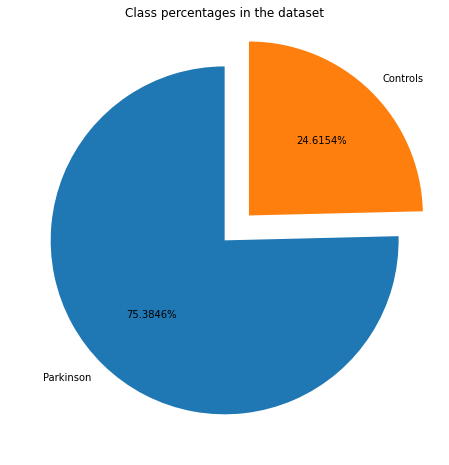

---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR 

In [ ]:
exploratory_analysis(dat)

## Distribución de las variables

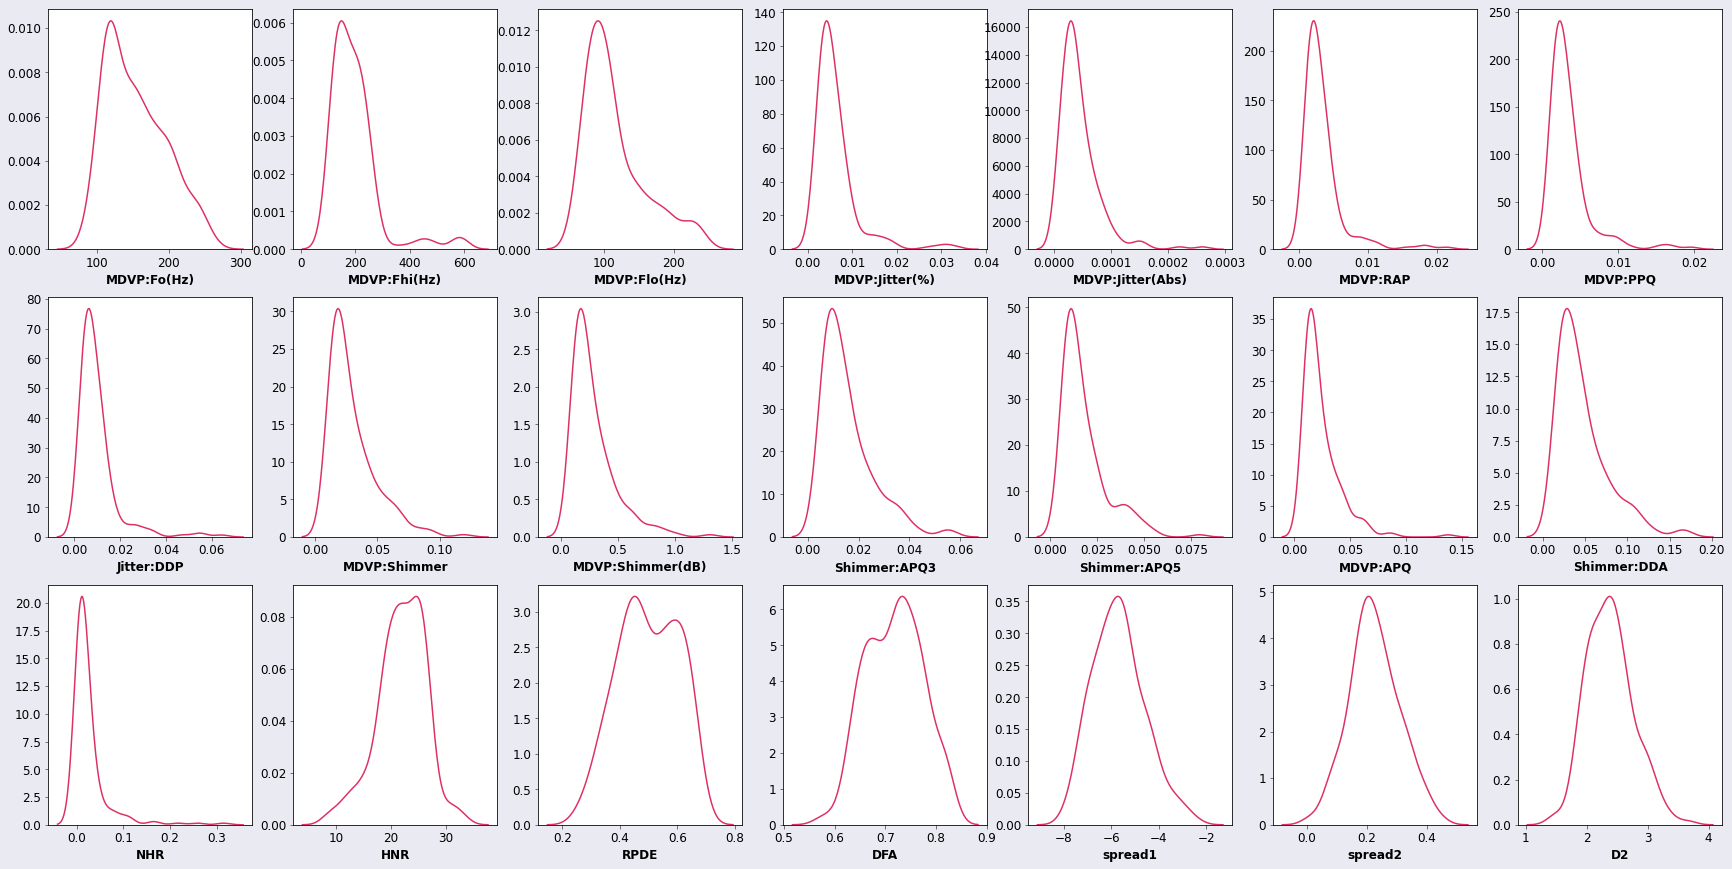

In [ ]:
feat = [col for col in dat.columns if col not in ['name', 'status']]
# Distrbución de las variables continuas
ncols = 7
nrows = int(len(feat) / ncols + (len(feat) % ncols > 0))-1

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 15), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = feat[r*ncols+c]
        sns.kdeplot(x=dat[col], ax=axes[r, c], color='#DE3163')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=12, fontweight='bold')
        axes[r, c].tick_params(labelsize=12, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

- Para la mayoría de variables, distribución ligeramente asimétrica a la derecha. 
- La mayoría de variables parecen presentar distribución normal. 

## Análisis de correlación e histogramas

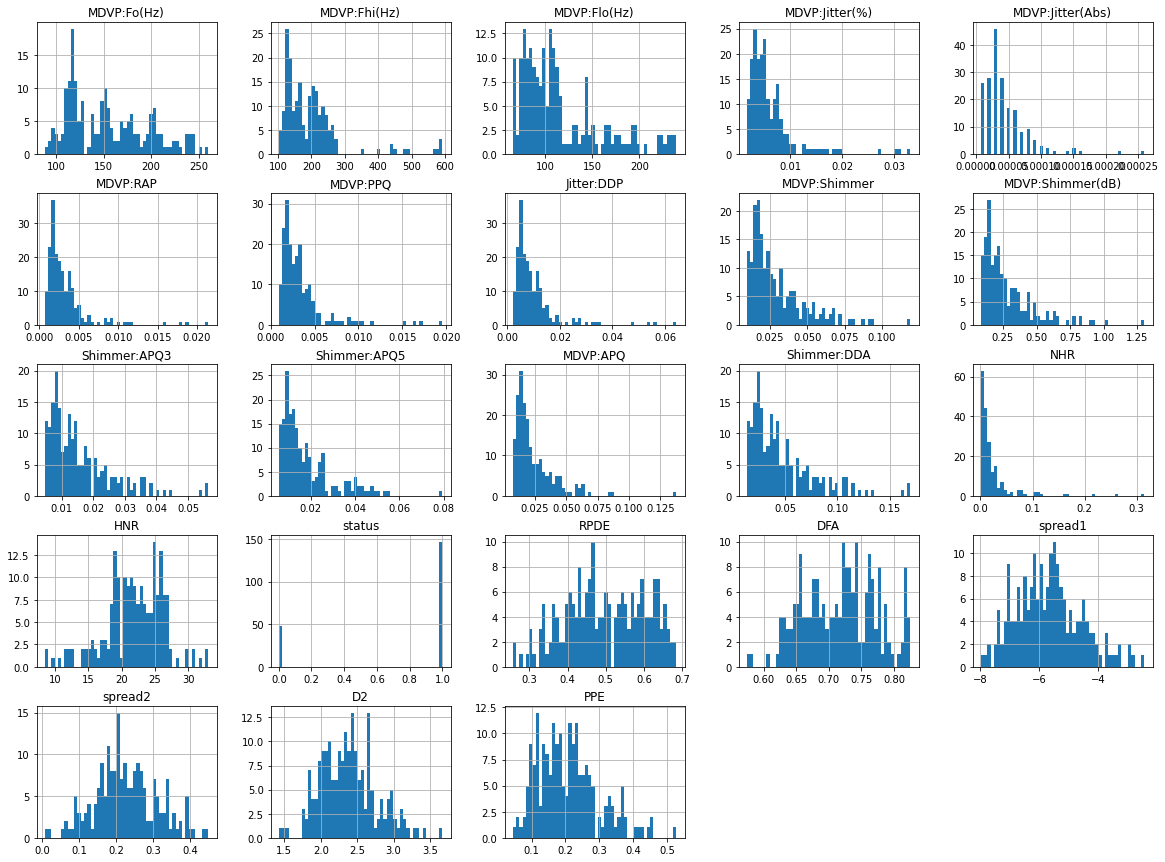

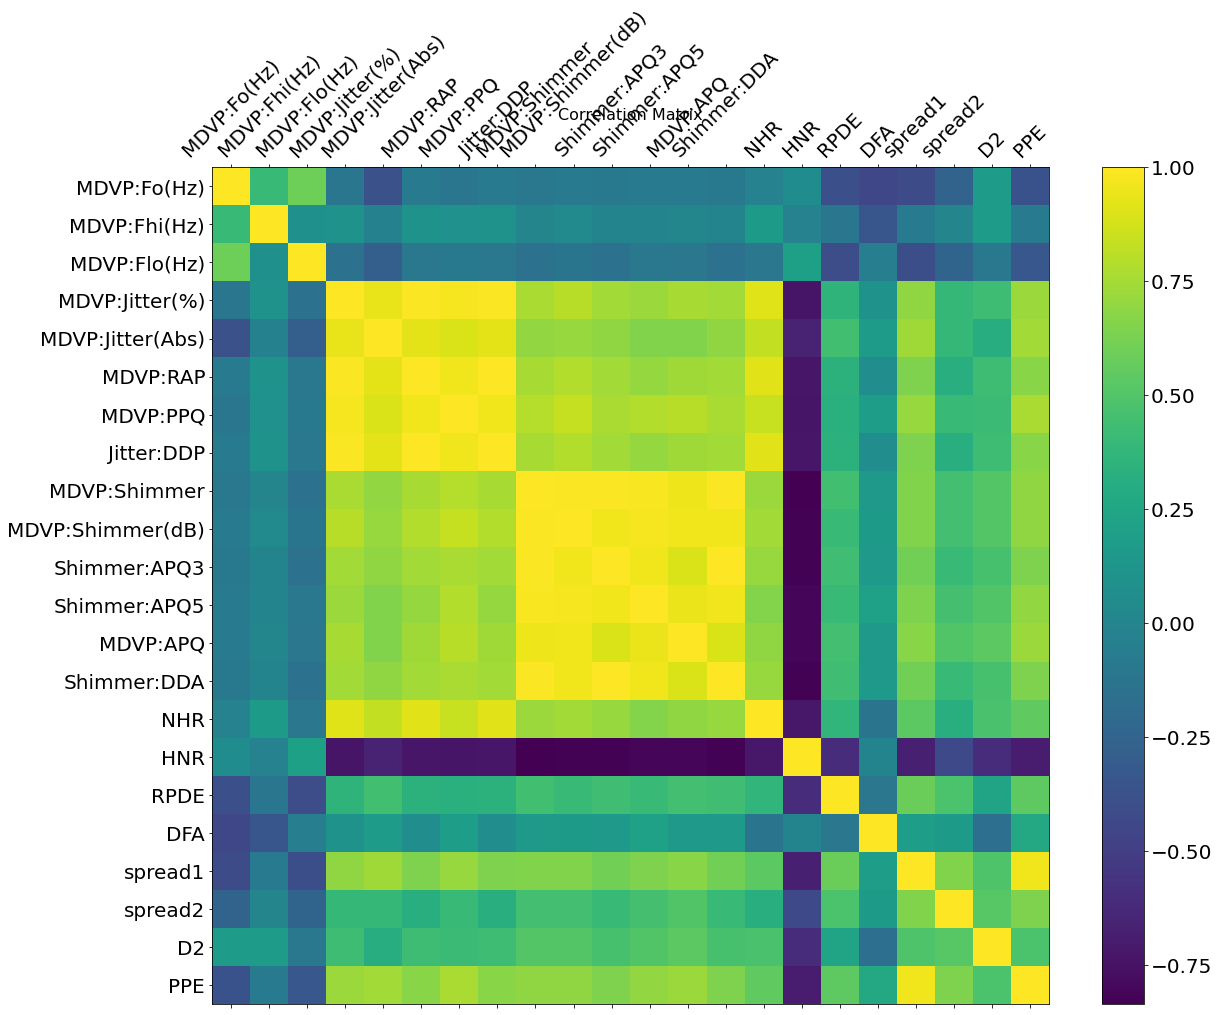

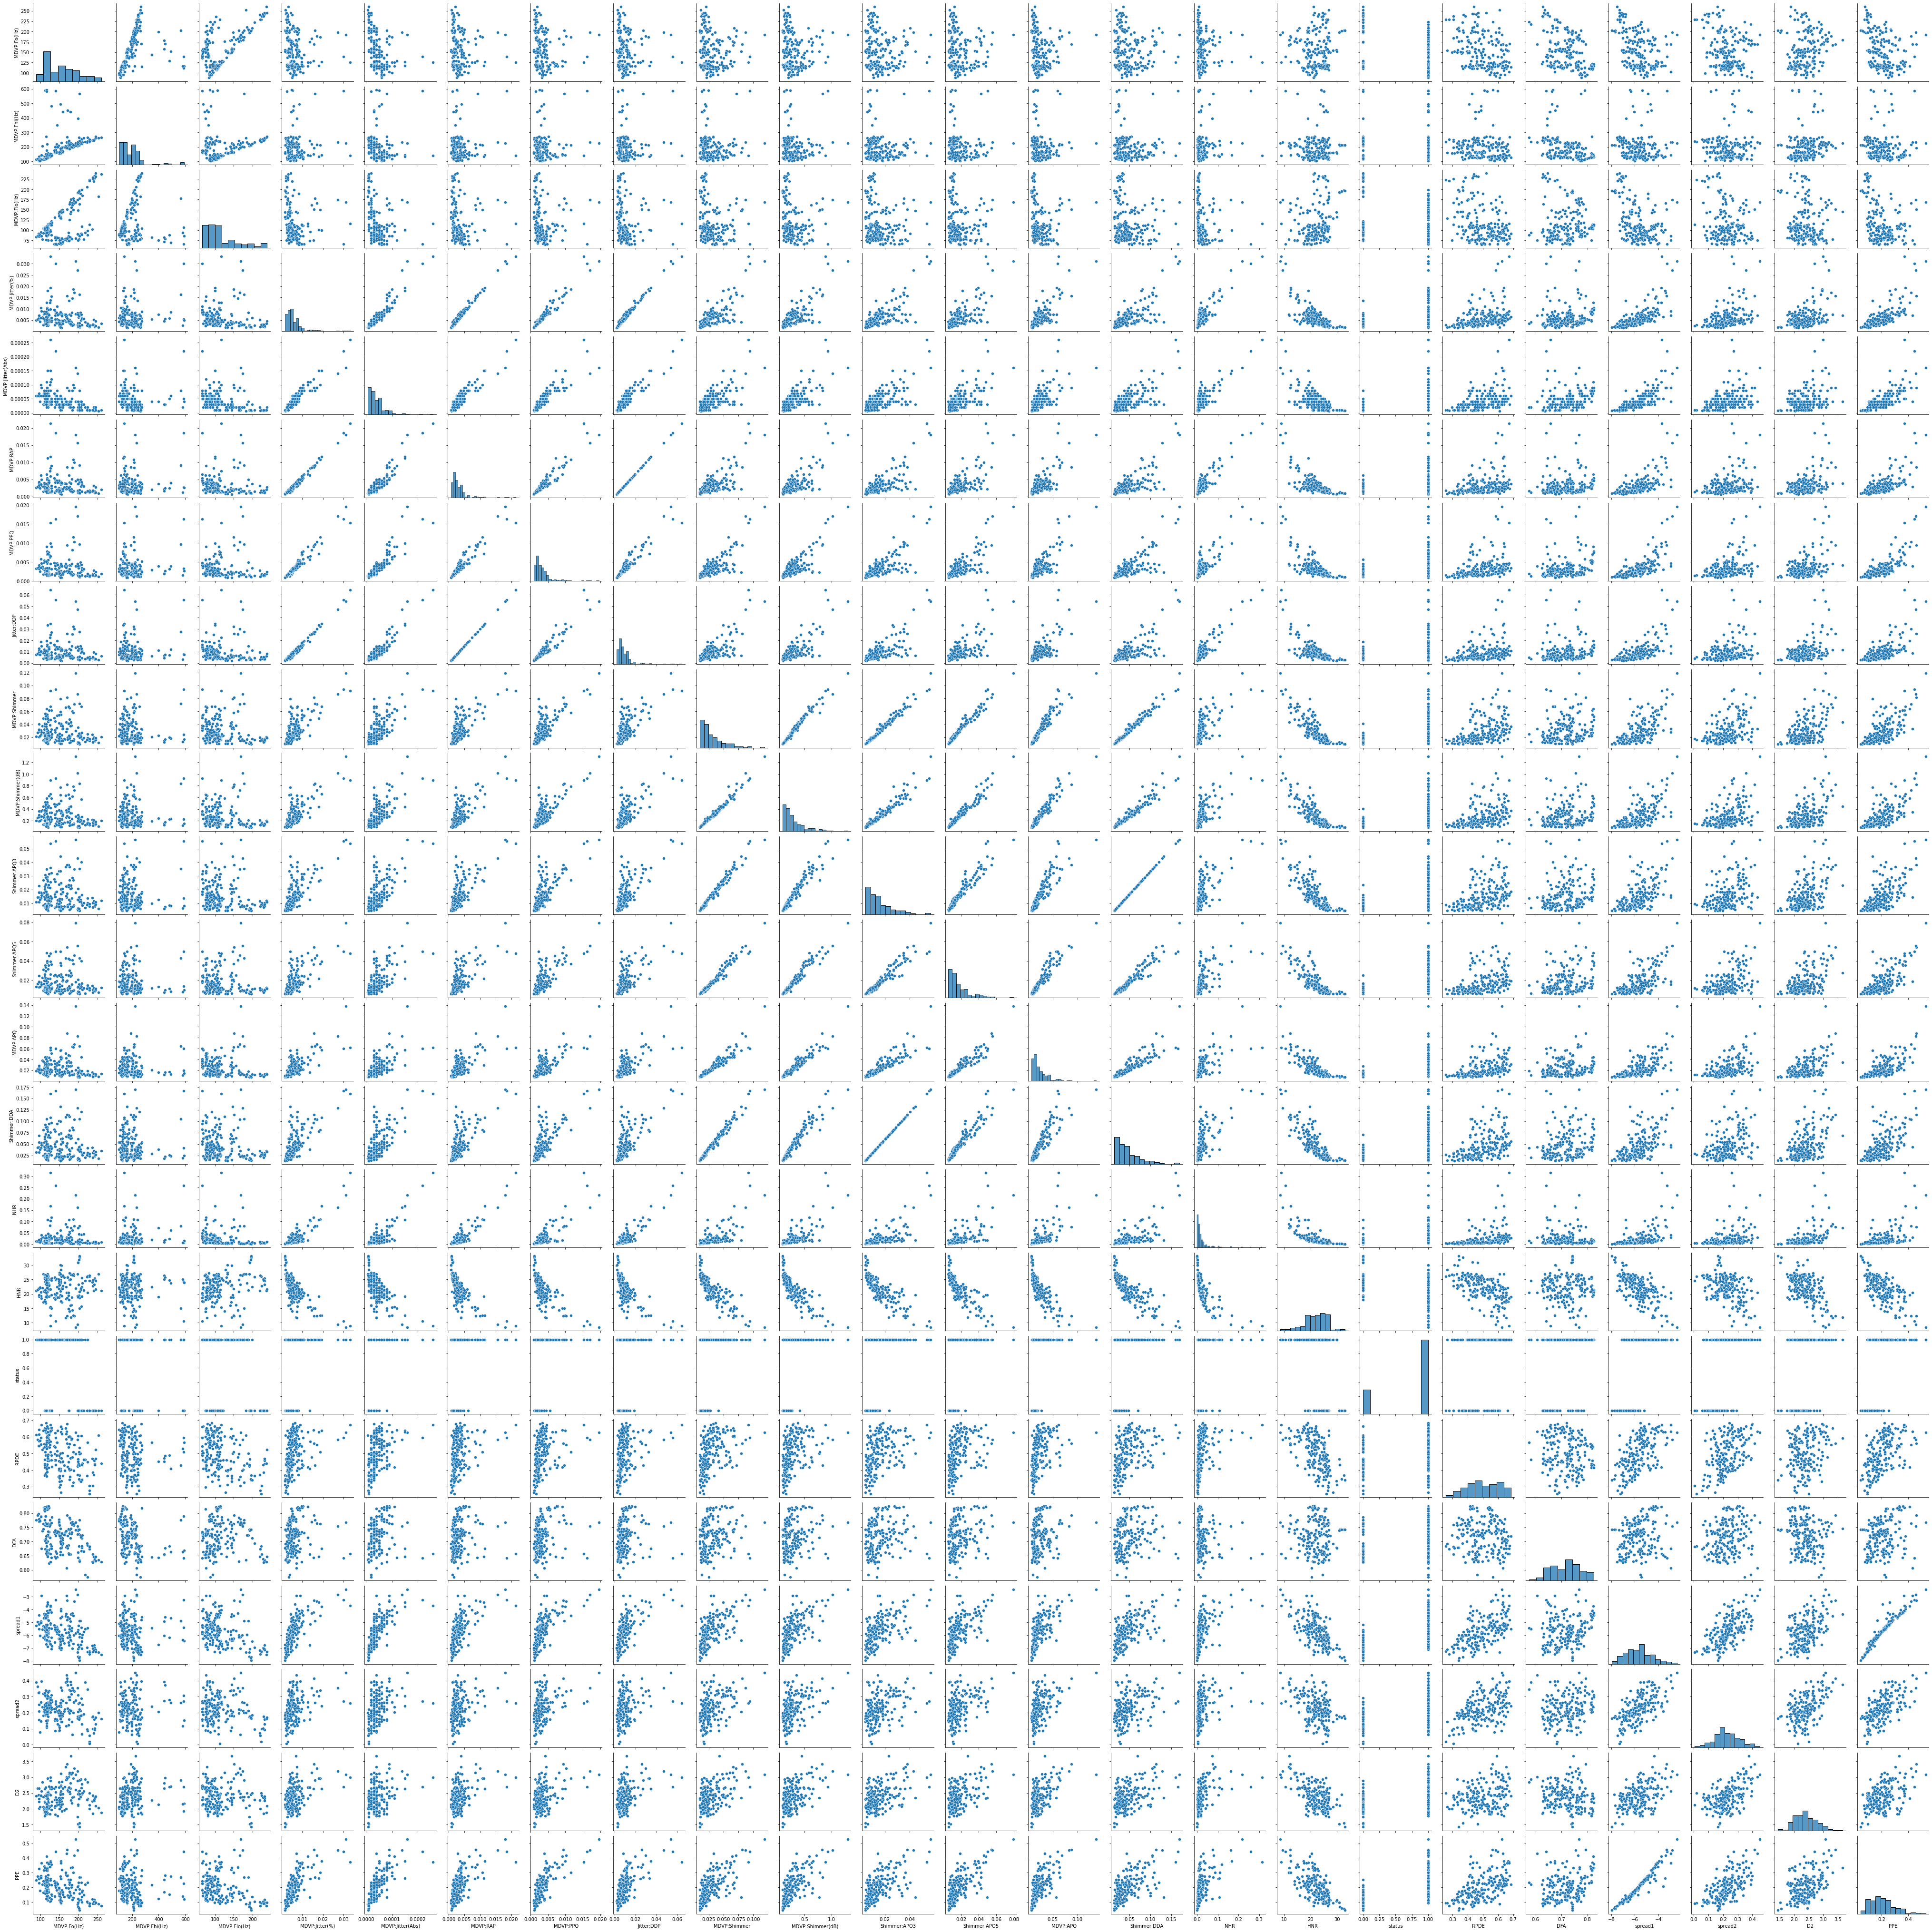

In [ ]:
hist_correlation_analysis(dat)

### Búsqueda de correlación entre variables

In [ ]:
# para mostrar qué variables se correlacionan con cuáles

corr_thresh = 0.6 # el threshold se puede cambiar aquí

corr_data = dat.corr()

highly_correlated_features = []

for feature in dat.columns:
    if feature == 'status' or feature == 'name':
        continue
    for feature_index in dat.columns:
        if feature_index == 'status' or feature_index == 'name':
            continue
        if feature == feature_index:
            continue
        if corr_data[feature][feature_index] > corr_thresh:
            tupla = (feature,feature_index)
            reversed_tupla = (feature_index, feature)
            if reversed_tupla in highly_correlated_features:
                continue
            highly_correlated_features.append((feature,feature_index))
            
highly_correlated_features

[('MDVP:Jitter(%)', 'MDVP:Jitter(Abs)'),
 ('MDVP:Jitter(%)', 'MDVP:RAP'),
 ('MDVP:Jitter(%)', 'MDVP:PPQ'),
 ('MDVP:Jitter(%)', 'Jitter:DDP'),
 ('MDVP:Jitter(%)', 'MDVP:Shimmer'),
 ('MDVP:Jitter(%)', 'MDVP:Shimmer(dB)'),
 ('MDVP:Jitter(%)', 'Shimmer:APQ3'),
 ('MDVP:Jitter(%)', 'Shimmer:APQ5'),
 ('MDVP:Jitter(%)', 'MDVP:APQ'),
 ('MDVP:Jitter(%)', 'Shimmer:DDA'),
 ('MDVP:Jitter(%)', 'NHR'),
 ('MDVP:Jitter(%)', 'spread1'),
 ('MDVP:Jitter(%)', 'PPE'),
 ('MDVP:Jitter(Abs)', 'MDVP:RAP'),
 ('MDVP:Jitter(Abs)', 'MDVP:PPQ'),
 ('MDVP:Jitter(Abs)', 'Jitter:DDP'),
 ('MDVP:Jitter(Abs)', 'MDVP:Shimmer'),
 ('MDVP:Jitter(Abs)', 'MDVP:Shimmer(dB)'),
 ('MDVP:Jitter(Abs)', 'Shimmer:APQ3'),
 ('MDVP:Jitter(Abs)', 'Shimmer:APQ5'),
 ('MDVP:Jitter(Abs)', 'MDVP:APQ'),
 ('MDVP:Jitter(Abs)', 'Shimmer:DDA'),
 ('MDVP:Jitter(Abs)', 'NHR'),
 ('MDVP:Jitter(Abs)', 'spread1'),
 ('MDVP:Jitter(Abs)', 'PPE'),
 ('MDVP:RAP', 'MDVP:PPQ'),
 ('MDVP:RAP', 'Jitter:DDP'),
 ('MDVP:RAP', 'MDVP:Shimmer'),
 ('MDVP:RAP', 'MDVP:Shimmer(

Todas las medidas de “Several measures of variation in fundamental frequency” (MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP)  están altamente y positivamente correlacionadas. Probablemente indiquen cosas equivalentes y podamos no usarlas todas para reducir la complejidad del modelo. A revisar.  


De forma similar, también están muy relacionadas entre ellas todas las medidas de “Several measures of variation in amplitude” (MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ, Shimmer:DDA). 

In [ ]:
# código por si quisiéramos eliminar del dataset alguna variable:

#features_to_be_removed = set()

#for feature_tuple in highly_correlated_features:
#   features_to_be_removed.add(feature_tuple[1])

#df.drop(features_to_be_removed,inplace=True, axis=1)

## Análisis exploratorio por estado

### Estadísticos descriptivos por estado

In [ ]:
dat.groupby('status').mean()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
status                                                            
0        181.937771    223.636750    145.207292        0.003866   
1        145.180762    188.441463    106.893558        0.006989   

        MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
status                                                                   
0               0.000023  0.001925  0.002056    0.005776      0.017615   
1               0.000051  0.003757  0.003900    0.011273      0.033658   

        MDVP:Shimmer(dB)  ...  MDVP:APQ  Shimmer:DDA       NHR        HNR  \
status                    ...                                               
0               0.162958  ...  0.013305     0.028511  0.011483  24.678750   
1               0.321204  ...  0.027600     0.053027  0.029211  20.974048   

            RPDE       DFA   spread1   spread2        D2       PPE  
status                                                              
0       0.442552  0.695716 -6.759264  0.160292  2.154491  0.123017  
1       0.516816  0.725408 -5.333420  0.248133  2.456058  0.233828  

[2 rows x 22 columns]

### Gráficos de barra para cada variable en función de estado

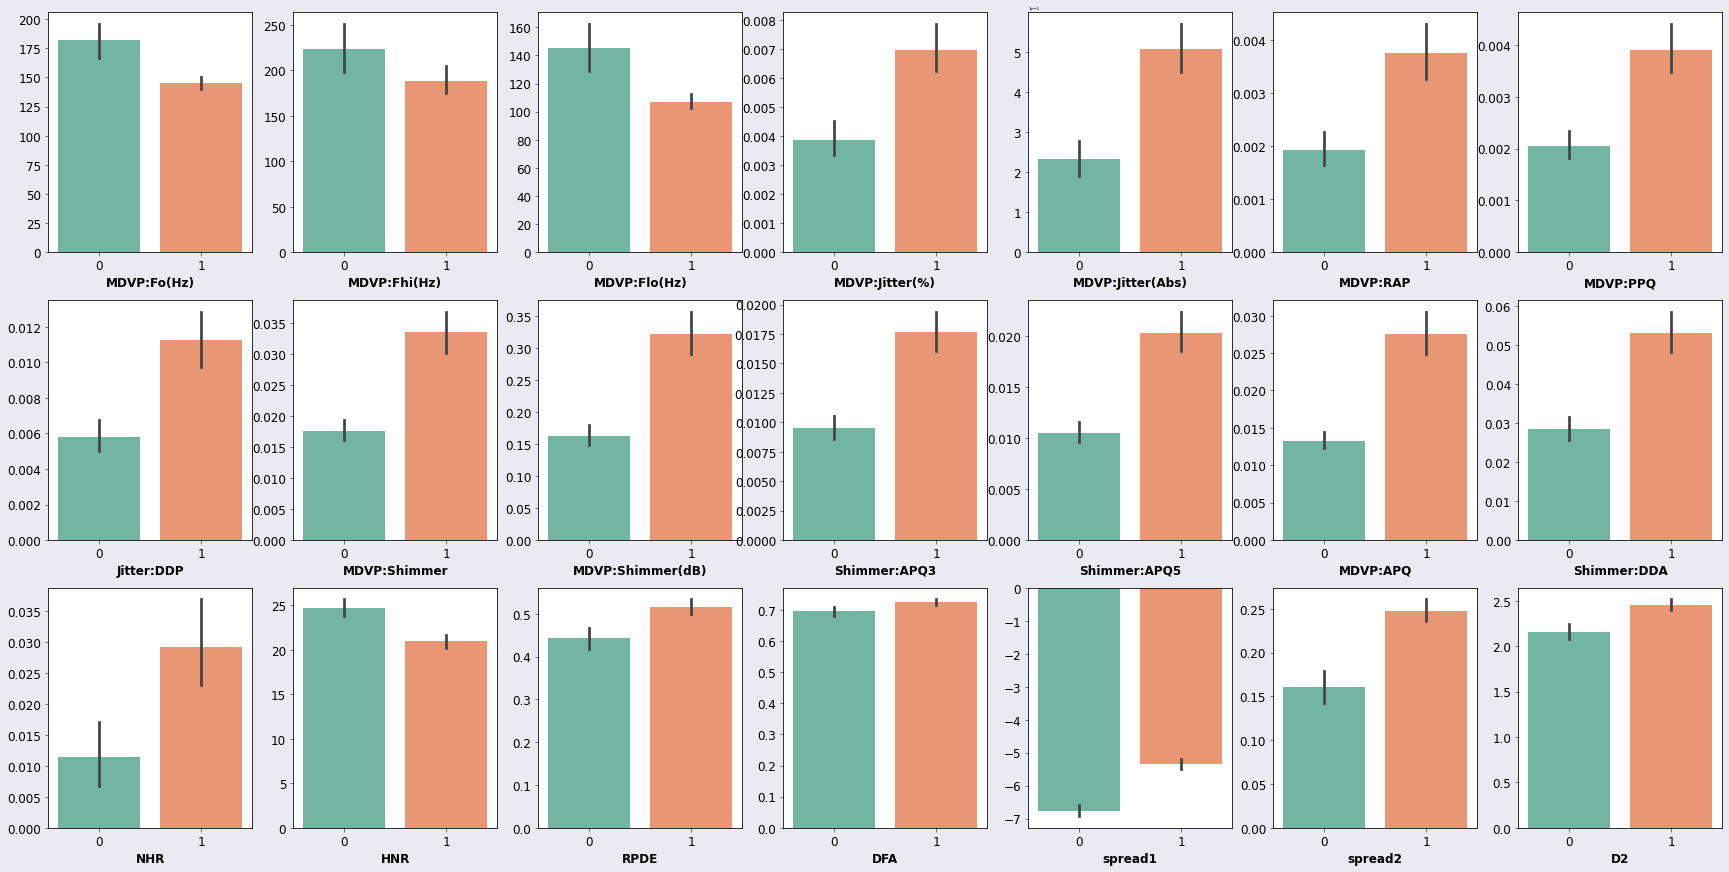

In [ ]:
feat = [col for col in dat.columns if col not in ['name', 'status']]
# gráficos de barras para las variables continuas (variable target en el eje X, variable contínua a plotear en eje Y) 
# 0 (Sano) -> magenta // 1 (Parkinson) -> orange 
ncols = 7
nrows = int(len(feat) / ncols + (len(feat) % ncols > 0))-1

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 15), facecolor='#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = feat[r*ncols+c]
        sns.barplot(y=dat[col], x=dat['status'], ax=axes[r, c], palette='Set2', label='Train data')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize=12, fontweight='bold')
        axes[r, c].tick_params(labelsize=12, width=0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

- Las tres medidas de “fundamental frequency” (tanto el promedio -MDVP:Fo- como el máximo -MDVP:Fhy- como el mínimo -MDVP:Flo-) muestran cierta relación negativa con la enfermedad. Las frecuencias son más bajas en personas con Parkinson.

- Todas las medidas de “variation in fundamental frequency” (MDVP:Jitter(%), MDVP:Jitter(Abs), MDVP:RAP, MDVP:PPQ, Jitter:DDP)  y de “variation in amplitude” (MDVP:Shimmer, MDVP:Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, MDVP:APQ,  Shimmer:DDA) muestran gráficos similares en lo que es la relación de la variable con la enfermedad. Todas van en la misma dirección y probablemente aporten poco en conjunto. Las variaciones son más altas en personas con Parkinson. 

- También parece ser claro diferenciador la variable NHR. El NHR es más alto en personas con Parkinson, aunque hay mucha dispersión en los datos.

- Lo contrario ocurre con la variable HNR (ratio of tonal components to noise in the voice). El HNR es más bajo en personas con Parkinson. 

- Con RFDE parece también haber relación, es más alto en personas con Parkinson, aunque la diferencia no es muy alta y es cercana a la dispersión. 

- DFA no parece aportar información relevante. Diferencias muy bajas entre enfermos y no enfermos. 

- Sí parecen ser buenos indicadores el spread1 y spread2. 


#### Algunas distribuciones que difieren entre sujetos sanos y sujetos con Parkinson

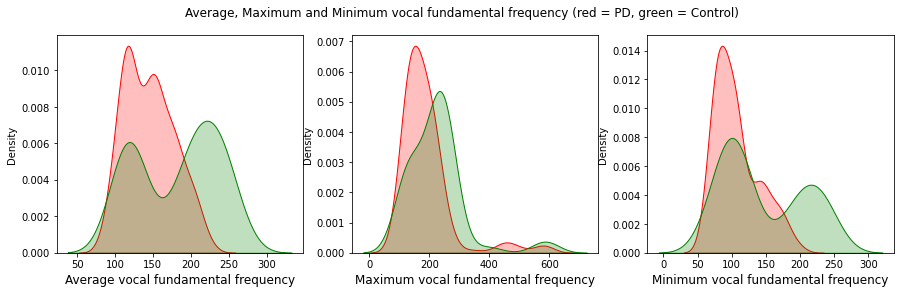

In [ ]:
plt.rcParams['figure.figsize'] = (15, 4)
plt.subplot(131)
sns.kdeplot(dat.loc[(dat['status']==1), 'MDVP:Fo(Hz)'], color='r', shade=True, Label='1')
sns.kdeplot(dat.loc[(dat['status']==0), 'MDVP:Fo(Hz)'], color='g', shade=True, Label='0')
plt.xlabel('Average vocal fundamental frequency', fontsize=12)

plt.subplot(132)
sns.kdeplot(dat.loc[(dat['status']==1), 'MDVP:Fhi(Hz)'], color='r', shade=True, Label='1')
sns.kdeplot(dat.loc[(dat['status']==0), 'MDVP:Fhi(Hz)'], color='g', shade=True, Label='0')
plt.xlabel('Maximum vocal fundamental frequency', fontsize=12)

plt.subplot(133)
sns.kdeplot(dat.loc[(dat['status']==1), 'MDVP:Flo(Hz)'], color='r', shade=True, Label='1')
sns.kdeplot(dat.loc[(dat['status']==0), 'MDVP:Flo(Hz)'], color='g', shade=True, Label='0')
plt.xlabel('Minimum vocal fundamental frequency', fontsize=12)

plt.suptitle('Average, Maximum and Minimum vocal fundamental frequency (red = PD, green = Control)')
plt.show()


- La distribución es menos homogénea en personas con Parkinson, y desplazada hacia valores más altos

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


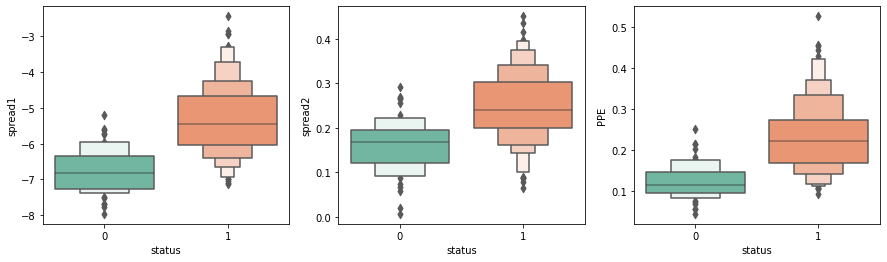

In [ ]:
plt.rcParams['figure.figsize'] = (15,4)
plt.subplot(131)
sns.boxenplot(dat['status'], dat['spread1'], palette = "Set2")

plt.subplot(132)
sns.boxenplot(dat['status'], dat['spread2'], palette = "Set2")

plt.subplot(133)
sns.boxenplot(dat['status'], dat['PPE'], palette ="Set2")

plt.show()

- Las medidas no lineales de variación en frecuencia fundamental son más altas en sujetos con Parkinson. 

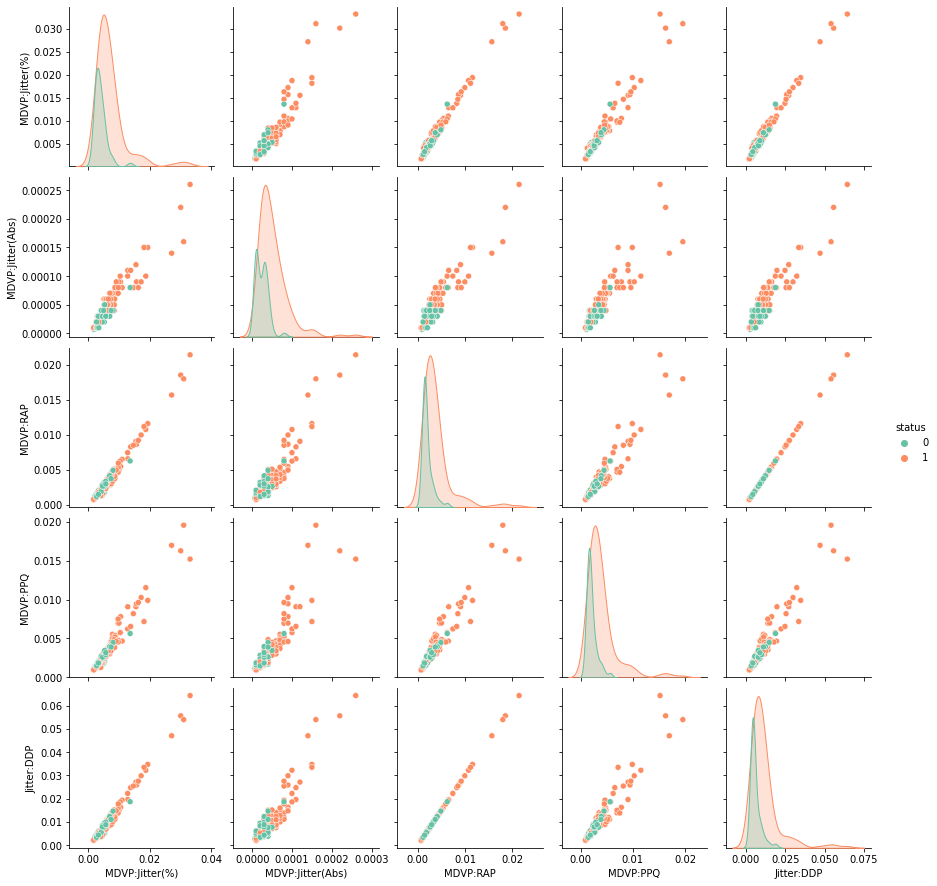

In [ ]:
plt.rcParams['figure.figsize'] = (15, 4)
sns.pairplot(dat,hue = 'status', vars = ['MDVP:Jitter(%)','MDVP:Jitter(Abs)','MDVP:RAP','MDVP:PPQ', 'Jitter:DDP'], palette="Set2" )
plt.show()

- Todas las medidas sobre variación en frecuencia fundamental, fuertemente relacionadas. Más variación en sujetos con Parkinson. 


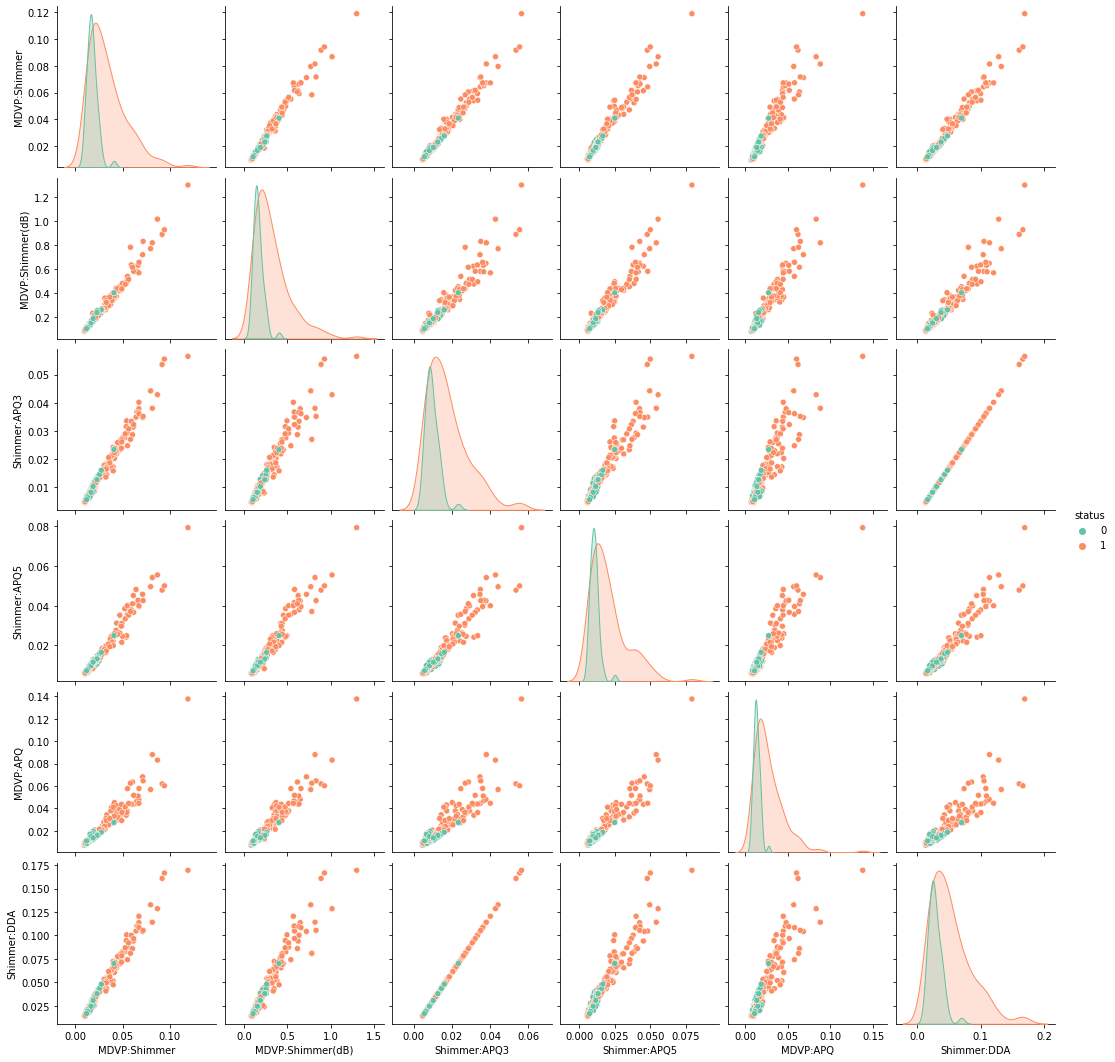

In [ ]:
plt.rcParams['figure.figsize'] = (15, 4)
sns.pairplot(dat,hue = 'status', vars = ['MDVP:Shimmer','MDVP:Shimmer(dB)','Shimmer:APQ3','Shimmer:APQ5','MDVP:APQ','Shimmer:DDA'], palette = "Set2")
plt.show()

- - Todas las medidas sobre variación en amplitud, fuertemente relacionadas. Más variación en sujetos con Parkinson. 

### Heatmap para la matriz de correlación según estado

In [ ]:
# Separamos los datos según sean de pacientes con Parkinson o de sujetos sanos para analizar 
# la colinealidad de las variables predictoras
parkinsons = dat[dat["status"] == 1]
controls = dat[dat["status"] == 0]

<Figure size 1296x576 with 0 Axes>

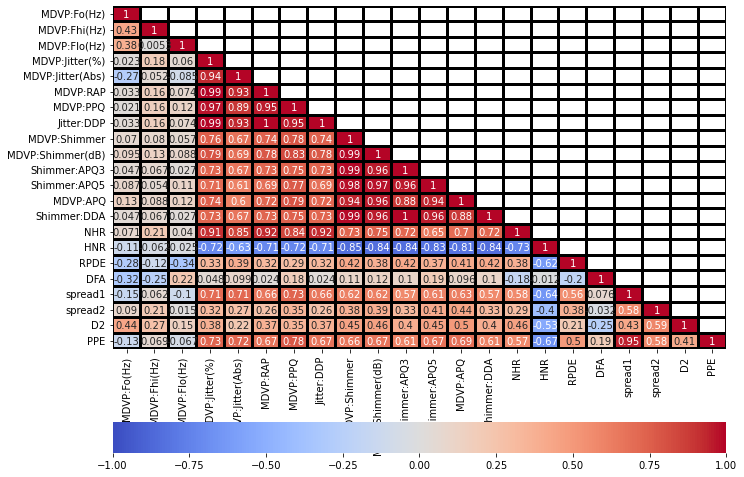

In [ ]:
parkinsons = parkinsons.select_dtypes(include=['float']) # solo float
corr = parkinsons.corr()                    # obtener las correlaciones
p_values = corr_sig(parkinsons)             # obtener los p-values
mask = np.invert(np.tril(p_values<0.05))    # filtro para las correlaciones significativas

# Heatmap para datos de sujetos con Parkinson con filtro de significancia
plt.figure(figsize=(18, 8))
plot_cor_matrix(corr,mask)  

<Figure size 1296x576 with 0 Axes>

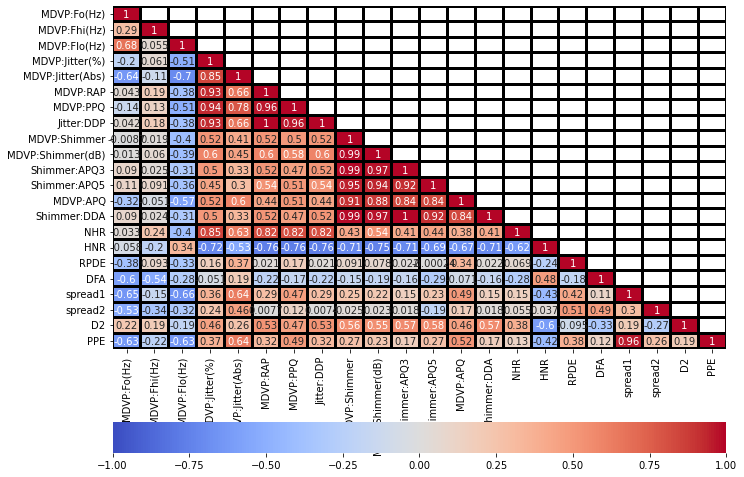

In [ ]:
controls = controls.select_dtypes(include=['float']) # solo float
corr = controls.corr()                    # obtener correlations
p_values = corr_sig(controls)             # obtener p-values
mask = np.invert(np.tril(p_values<0.05))    # filtrar solo las correlaciones significativas

# Heatmap para datos de sujetos sanos con filtro de significancia
plt.figure(figsize=(18, 8))
plot_cor_matrix(corr,mask)  

 
- Muchas variables están correlacionadas.
- Puede ser necesario aplicar medidas para evitar colinealidad.

## Comprobar información de clasificación mutua

La Información Mutua entre dos variables aleatorias es un valor no negativo que mide la dependencia entre las variables. Es igual a cero si y solo si dos variables aleatorias son independientes, valores más elevados indican dependencia más alta. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


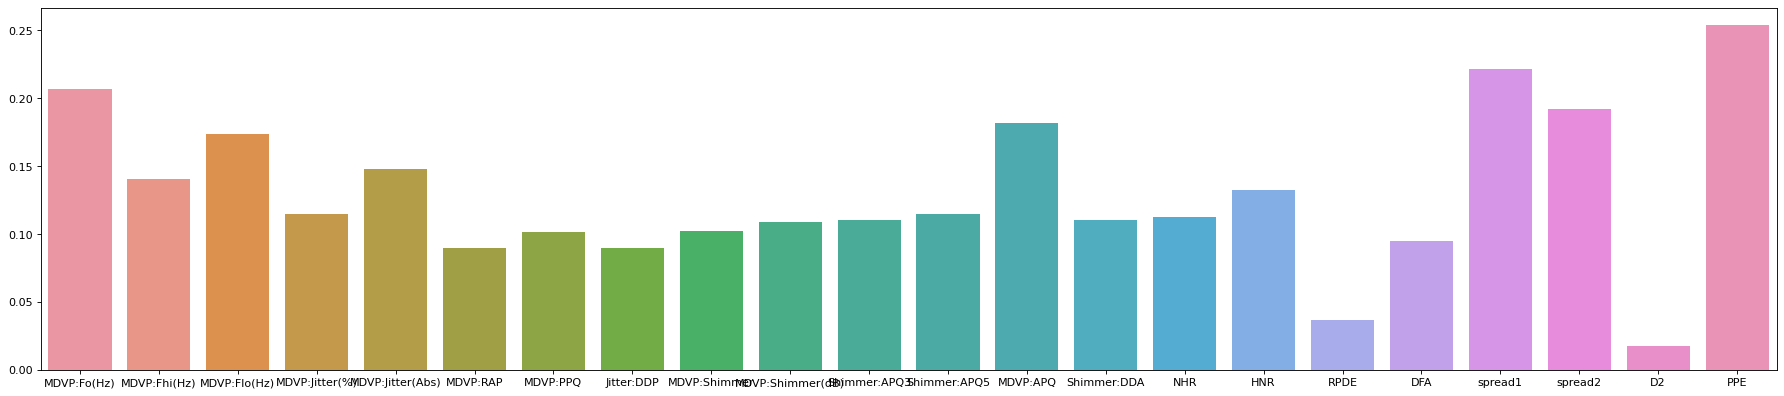

In [ ]:
# mutual info classification
from sklearn.feature_selection import mutual_info_classif

predictors = dat.drop(['name','status'], axis=1)
dependentvar = dat['status']

mutual_info = mutual_info_classif(predictors, dependentvar)
# imprimir mutual_info
from matplotlib.pyplot import figure

figure(figsize=(28, 6), dpi=80)
sns.barplot(predictors.columns, mutual_info);

# División del dataset en train y test

In [ ]:
# si se usa SMOTE: 
#y = y_resample 
#x = x_resample

# si no se usa SMOTE:
x=dat.drop('status', axis=1)
x=x.drop('name', axis=1)
y=dat[['status']]

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=12)

In [ ]:
print(x.shape, x_train.shape, x_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(195, 22) (156, 22) (39, 22)
(195, 1) (156, 1) (39, 1)


# Estandarización

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler
#features=data.loc[:,dat.columns!='status'].values[:,1:]
#labels=data.loc[:,'status'].values
#scaler=MinMaxScaler((-1,1)) # minmax ?
scaler = StandardScaler()
#scaler = RobustScaler() # using statistics robust to outliers
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


# Modelos

La performance de los modelos se medirá con los siguientes parámetros:
1. Matriz de confusión = tabla con 4 diferentes combinaciones de los valores reales y los actuales, para este clasificador binario (positivo real, falso positivo, negativo real, falso negativo).
2. Accuracy = la fracción total de predicciones acertadas.
3. Precision = la fracción de positivos predichos que eran positivos reales.[True positive / (True Positive + False positive)]
4. Recall = la fracción de positivos reales que han sido correctamente predichos. [True positive / (True Positive + False negative)]
5. F1 score = (Precision X Recall) / (Precision + Recall). Los valores van de 0 (malo) a 1 (bueno). El clasificador solo será bueno si tanto la Precision como el Recall son buenos

In [ ]:


conf_matrix_all = {}
# de https://www.kaggle.com/code/adityakadiwal/parkinsons-disease-detection

def parkinsons_disease_prediction(name, algo, training_x, testing_x, training_y, testing_y, plot) :
    algo.fit(training_x,training_y)                           # Hacer Fit del training data set al algoritmo pasado.
    predictions = algo.predict(testing_x)                     # Obtener las predicciones
    probabilities = algo.predict_proba(testing_x)             # Obtener las probabilidades de las predicciones

    conf_matrix = confusion_matrix(testing_y, predictions)    # Obtener la matriz de confusión
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp+tn)/(tn+tp+fn+fp)
    
    conf_matrix_all[name] = conf_matrix                       # Guardar la matriz de confusión en un diccionario
    
    print("Classification report:")                           # Imprimir el informe de clasificación
    print(classification_report(testing_y, predictions))

    print("\nSensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)")
    print(tp / (tp + fn))

    print("\nSpecificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)")
    print(tn / (tn + fn))

    model_roc_auc = roc_auc_score(testing_y, predictions)           # Obtener el área bajo la curva
    fpr,tpr,thresholds = roc_curve(testing_y, probabilities[:,1])   # Obtener los False postive rate y True positive rate
    
    print ("\nArea under the curve: ", model_roc_auc)
    
    if plot:
        fig, axes = plt.subplots(1,2, figsize=(20, 7))
        conf_matrix = np.flip(conf_matrix)
        plt.rcParams.update({'font.size': 22})

        labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
        labels = np.core.defchararray.add(conf_matrix.astype(str), labels)
        sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[0], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);                                           # Plot the confusion matrix
        axes[0].set(xlabel='Predicted', ylabel='Actual')

        plt.title('Receiver Operating Characteristic')
        sns.lineplot(fpr, tpr, ax=axes[1])                                         # Graficar la curva ROC
        plt.plot([0, 1], [0, 1],'--')                                              # Graficar la línea diagonal
        axes[1].set_xlim([0, 1])                                                   # Poner el límite del eje X en 0 y 1
        axes[1].set_ylim([0, 1])                                                   # Poner el límite del eje Y en 0 y 1
        axes[1].set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate');
        plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
        plt.show();

    return model_roc_auc, accuracy

## 1. **KNN**

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Classification report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.90      0.97      0.93        29

    accuracy                           0.90        39
   macro avg       0.89      0.83      0.86        39
weighted avg       0.90      0.90      0.89        39


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.9655172413793104

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.875

Area under the curve:  0.8327586206896551


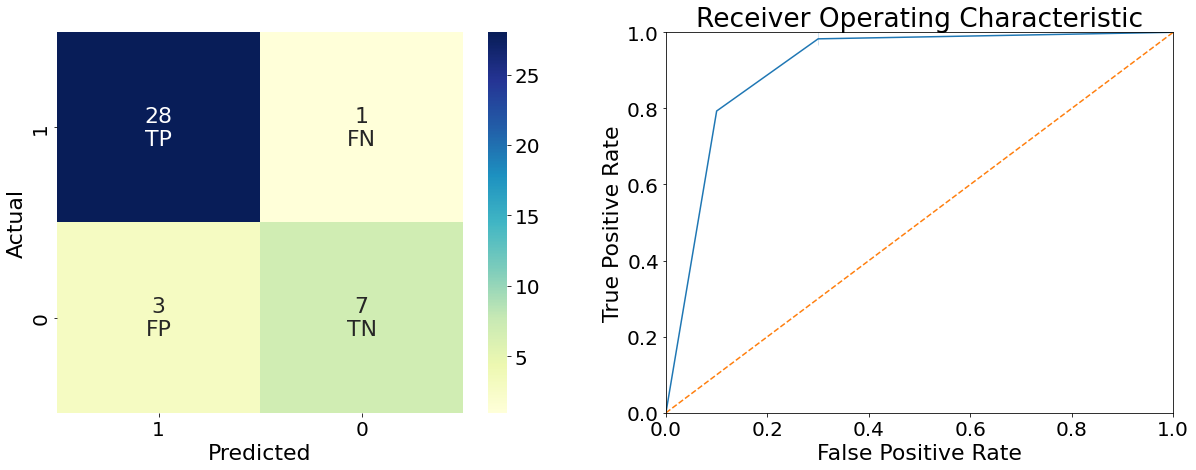

In [ ]:
#knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', metric_params=None, n_neighbors = 2, weights='distance')
knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=28, metric='minkowski', metric_params=None, n_neighbors = 3, weights='uniform') # with values from optuna (see end)

auc_knn, acc_knn = parkinsons_disease_prediction("K-Nearest Neighbours", knn, x_train, x_test, y_train, y_test, plot=True)


## 2. **Support vector machine**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.85      0.97      0.90        29

    accuracy                           0.85        39
   macro avg       0.84      0.73      0.76        39
weighted avg       0.84      0.85      0.83        39


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.9655172413793104

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.8333333333333334

Area under the curve:  0.7327586206896552


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


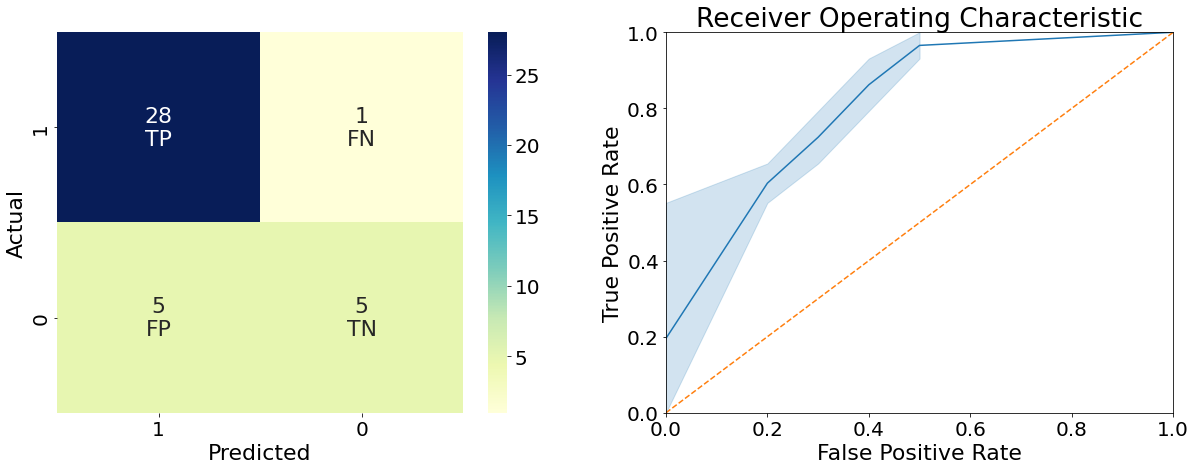

In [ ]:
from sklearn.svm import SVC
svc1 = SVC(C=1.0, kernel='linear', degree= 2, gamma=1.0, random_state=None,
          coef0=0.0, shrinking=True, probability=True,tol=0.001,
          cache_size=200, class_weight=None, verbose=False,max_iter= -1)

auc_svm, acc_svm = parkinsons_disease_prediction("Support Vector Classifier", svc1, x_train, x_test, y_train, y_test, plot=True)

## 3. **Naive Bayes**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       1.00      0.72      0.84        29

    accuracy                           0.79        39
   macro avg       0.78      0.86      0.78        39
weighted avg       0.89      0.79      0.81        39


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.7241379310344828

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.5555555555555556

Area under the curve:  0.8620689655172413


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


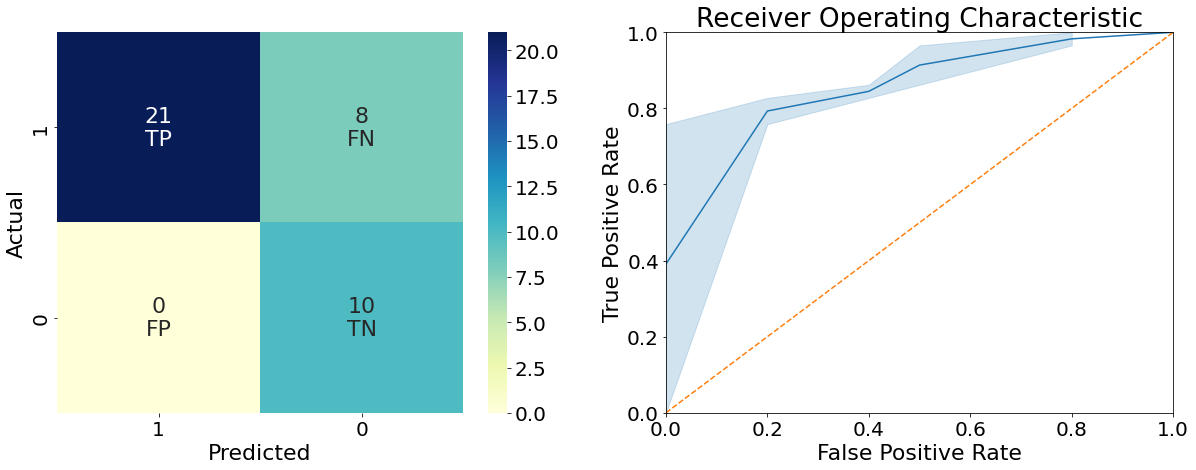

In [ ]:
gnb = GaussianNB(priors=None, var_smoothing=1e-09)
auc_nb, acc_nb = parkinsons_disease_prediction("Gaussian Naïve Bayes", gnb, x_train, x_test, y_train, y_test, plot=True)

## 4. **Random Forest**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Classification report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.9655172413793104

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.8888888888888888

Area under the curve:  0.8827586206896553


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


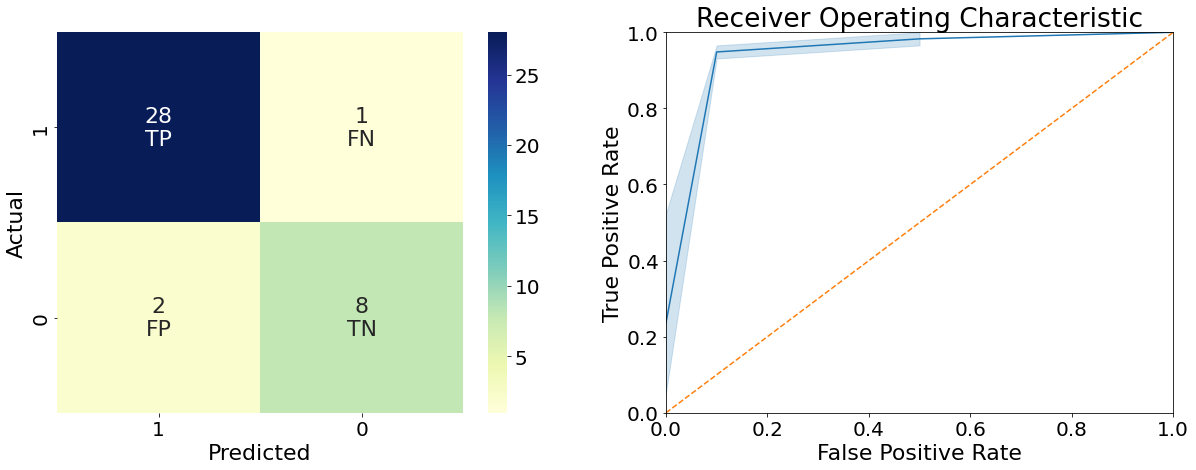

In [ ]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, criterion = "gini", 
                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                               warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

auc_rf, acc_rf = parkinsons_disease_prediction("Random Forest", rfc,x_train, x_test, y_train, y_test, plot=True) 

## 5. **Bagging Classifier**

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Classification report:
              precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.88      0.97      0.92        29

    accuracy                           0.87        39
   macro avg       0.87      0.78      0.81        39
weighted avg       0.87      0.87      0.86        39


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.9655172413793104

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.8571428571428571

Area under the curve:  0.7827586206896553


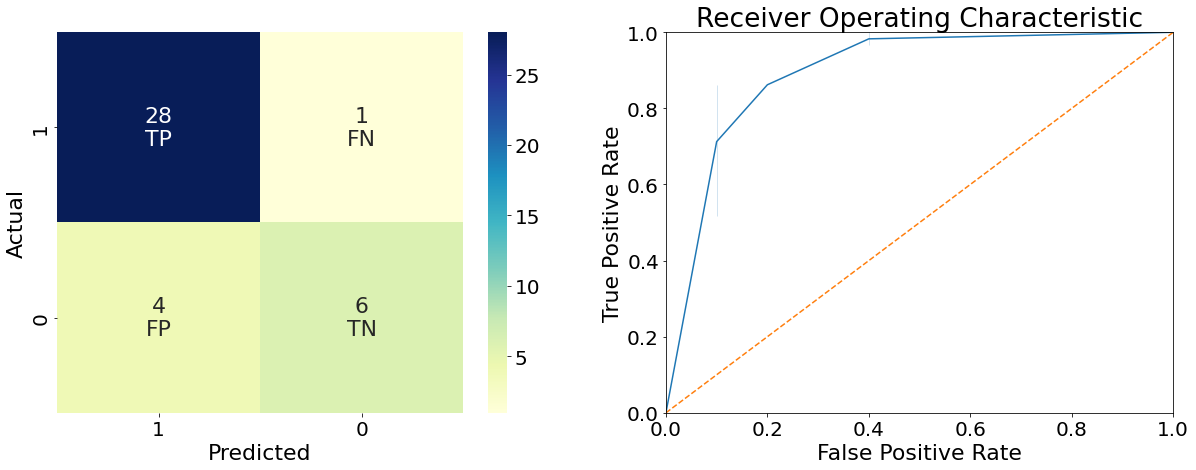

In [ ]:
bcc = BaggingClassifier()

auc_bc, acc_bc = parkinsons_disease_prediction("Bagging Classifier", bcc,x_train, x_test, y_train, y_test, plot=True) 

## 6. **XGBoost**

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.85      0.97      0.90        29

    accuracy                           0.85        39
   macro avg       0.84      0.73      0.76        39
weighted avg       0.84      0.85      0.83        39


Sensitivity measure: True Positive Rate (TPR) or the proportion of identified positives among the parkinson-positive population (class = 1)
0.9655172413793104

Specificity measure: True Negative Rate (TNR), that is the proportion of identified negatives among the parkinson-negative population (class = 0)
0.8333333333333334

Area under the curve:  0.7327586206896552


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


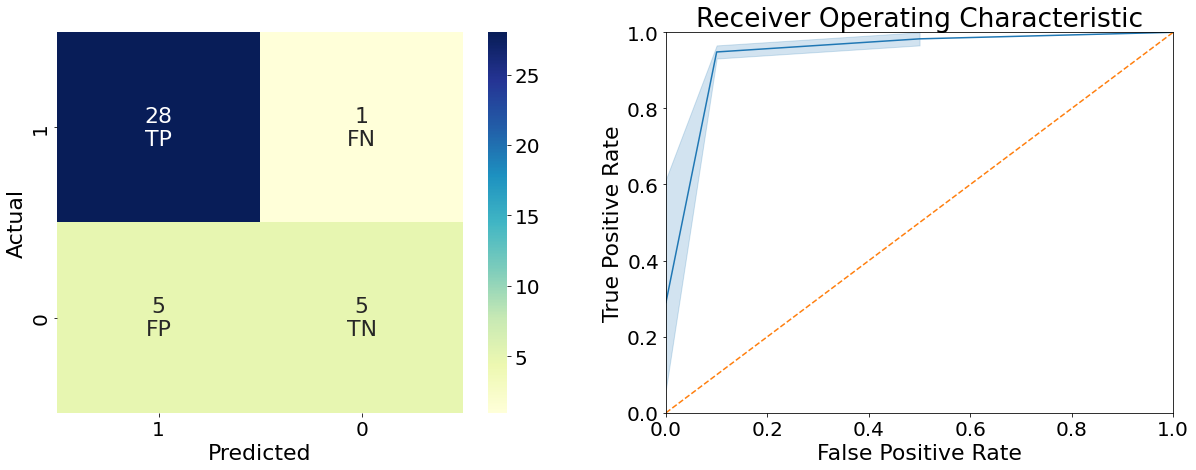

In [ ]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                        max_depth = 6, min_child_weight=1, missing=None, n_estimators=50,
                        objective='binary:logistic', random_state=0, reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, subsample=0.8)
auc_xgb, acc_xgb = parkinsons_disease_prediction("XGBoost", xgb,x_train, x_test, y_train, y_test, plot=True) 

## 7. Catboost

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


Learning rate set to 0.00466
0:	learn: 0.6880919	total: 52.1ms	remaining: 52s
1:	learn: 0.6834879	total: 57.3ms	remaining: 28.6s
2:	learn: 0.6797940	total: 62.6ms	remaining: 20.8s
3:	learn: 0.6757360	total: 66.7ms	remaining: 16.6s
4:	learn: 0.6708491	total: 71.1ms	remaining: 14.2s
5:	learn: 0.6663077	total: 75.2ms	remaining: 12.5s
6:	learn: 0.6615165	total: 79.5ms	remaining: 11.3s
7:	learn: 0.6562743	total: 83.7ms	remaining: 10.4s
8:	learn: 0.6518953	total: 87.9ms	remaining: 9.68s
9:	learn: 0.6462360	total: 92.1ms	remaining: 9.12s
10:	learn: 0.6415530	total: 96.3ms	remaining: 8.66s
11:	learn: 0.6358399	total: 101ms	remaining: 8.28s
12:	learn: 0.6307130	total: 105ms	remaining: 7.95s
13:	learn: 0.6264965	total: 109ms	remaining: 7.68s
14:	learn: 0.6227417	total: 113ms	remaining: 7.43s
15:	learn: 0.6183515	total: 117ms	remaining: 7.21s
16:	learn: 0.6134480	total: 122ms	remaining: 7.03s
17:	learn: 0.6104231	total: 126ms	remaining: 6.86s
18:	learn: 0.6064442	total: 130ms	remaining: 6.7s
19:	

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


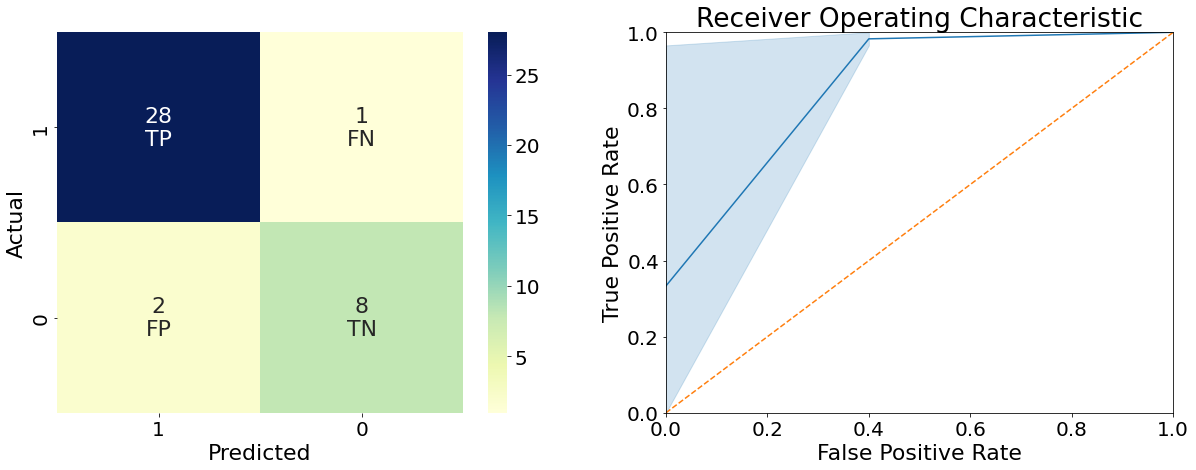

In [ ]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(depth=6)
auc_cat, acc_cat = parkinsons_disease_prediction("Cat Boost", cb, x_train, x_test, y_train, y_test, plot=True)

## Resumen de las performances de todos los modelos

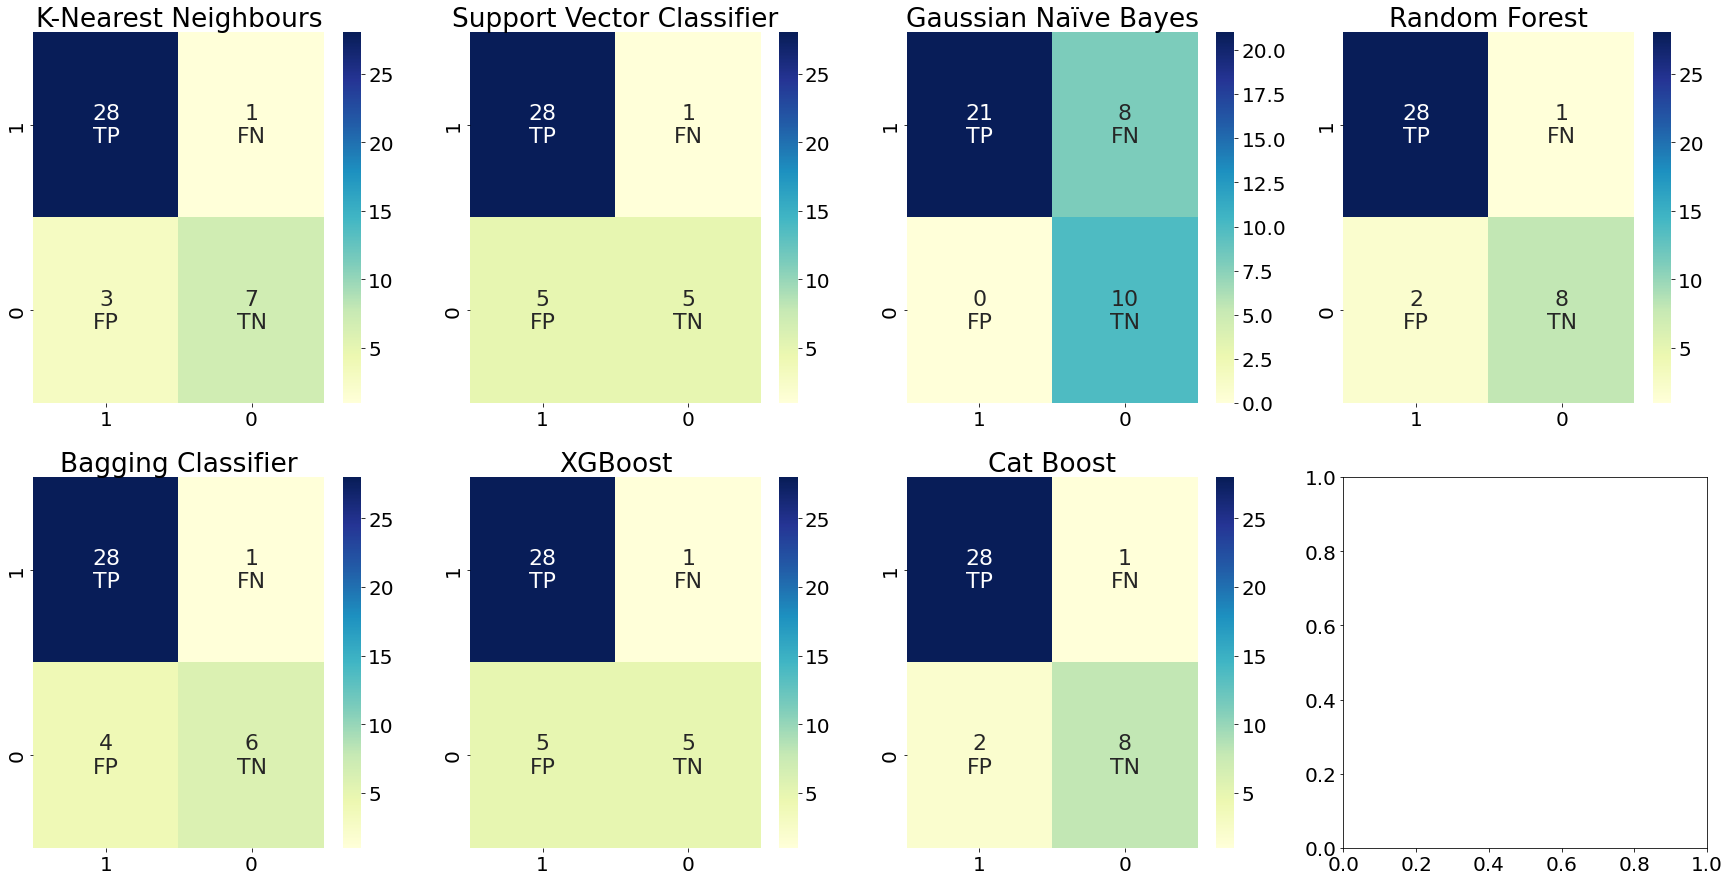

In [ ]:
import math
fig, axes = plt.subplots(2, 4, figsize = (30, 15))

acc = [acc_knn, acc_svm, acc_nb, acc_rf, acc_bc, acc_xgb, acc_cat]

cnt = 0
for r in range(4):
    for c in range(4):
        try:
            conf_matrix = np.flip(list(conf_matrix_all.values())[cnt])
            labels = np.array([['\nTP','\nFN'],['\nFP','\nTN']])
            labels = np.core.defchararray.add(conf_matrix.astype(str), labels)

            sns.heatmap(conf_matrix, fmt='', annot = labels, ax=axes[r, c], cmap="YlGnBu", xticklabels=[1, 0], yticklabels=[1, 0]);
            axes[r, c].set(title=list(conf_matrix_all.keys())[cnt])
            cnt += 1
        except:
            pass

In [ ]:
auc_cat, acc_cat

In [ ]:
print('ACCURACIES:\n KNN = '+str(acc_knn) + '\n SVM = '+str(acc_svm) + '\n NB = '+str(acc_nb) + '\n RF = '+str(acc_rf) + '\n BC = '+str(acc_bc) + '\n XGB = '+str(acc_xgb) + '\n CAT = '+str(acc_cat))
print('\n')
print('AREA UNDER THE CURVE:\n KNN = '+str(auc_knn) + '\n SVM = '+str(auc_svm) + '\n NB = '+str(auc_nb) + '\n RF = '+str(auc_rf) + '\n BC = '+str(auc_bc) + '\n XGB = '+str(auc_xgb) + '\n CAT = '+str(auc_cat))

ACCURACIES:
 KNN = 0.8974358974358975
 SVM = 0.8461538461538461
 NB = 0.7948717948717948
 RF = 0.9230769230769231
 BC = 0.8717948717948718
 XGB = 0.8461538461538461
 CAT = 0.9230769230769231


AREA UNDER THE CURVE:
 KNN = 0.8327586206896551
 SVM = 0.7327586206896552
 NB = 0.8620689655172413
 RF = 0.8827586206896553
 BC = 0.7827586206896553
 XGB = 0.7327586206896552
 CAT = 0.8827586206896553


# Conclusión

Los modelos Random Forest y CatBoost aportan la mejor performance. 
No se ha aplicado ninguna limpieza de variables al tratarse de un dataset con muy pocos datos, lo que podría restar potencia al modelo. 
La performance obtenida es muy buena, con una Accuracy de 0.92 y una AUC de 0.88.